In [1]:
# Source: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [2]:
#autoreload
%load_ext autoreload
%autoreload 2

In [3]:
try:
  import google.colab
  IN_COLAB = True

  from google.colab import drive
  drive.mount('/content/gdrive')
except:
  IN_COLAB = False

### CONFIGs

Here we set the experiments to run

In [4]:
experiment_name = 'conv_spadeSCRes'

In [5]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings
import torch
if IN_COLAB:
    folder = "/content/gdrive/MyDrive/MILA_BOYS_FINAL/Final_Deliverable" #@param {type:"string"}
    !ln -Ts $folder /content/Final_Deliverable 2> /dev/null

    # Add the assignment folder to Python path
    if '/content/Final_Deliverable' not in sys.path:
        sys.path.insert(0, '/content/Final_Deliverable')

    # Install requirements
    !pip install -qr /content/Final_Deliverable/requirements.txt
else:
    sys.path.insert(0, '../')

# Check if CUDA is available
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available.')


C:\Users\saiak\AppData\Local\Temp\ipykernel_34128\3720997126.py:26: UserWarning: CUDA is not available.
  warnings.warn('CUDA is not available.')


In [6]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

import numpy as np
import sys
import segmentation_models_pytorch as smp
from Models.SpadeUnet.TigerBlocks import TigerUnet
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import train 
import random

In [7]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [8]:
if IN_COLAB:
    ROOT_DIR = 'Final_Deliverable'
    DATA_DIR = "Final_Deliverable/Data/process_data"
else:
    ROOT_DIR = '../'
    DATA_DIR = "../Data/process_data"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'valid_masks')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

context_dir = os.path.join(DATA_DIR, 'context')

IMG_SIZE = (128, 128)
BATCH_SIZE = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        context_dir (str): path to contextual images folder
        classes (list): values of classes to extract from segmentation mask
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = ['non-tumor', 'tumor']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            context_dir,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [fname for fname in os.listdir(images_dir) if os.path.exists(os.path.join(context_dir,fname)) and fname != "desktop.ini"]
    
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.contexts_fps = [os.path.join(context_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        try: 
            # read data
            image = cv2.imread(self.images_fps[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.masks_fps[i], 0)
            ctx = cv2.imread(self.contexts_fps[i])
            ctx = cv2.cvtColor(ctx, cv2.COLOR_BGR2RGB)
        except:
            raise Exception('fname {}'.format(self.contexts_fps[i]))
            
        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.preprocessing:
            image, mask = self.preprocessing(image), self.preprocessing(mask)
            image = image / 255
            ctx = transforms.functional.resize(transforms.functional.to_tensor(ctx), size=[256 ,256])
            ctx = ctx / 255
        
        return image, mask, ctx
        
    def __len__(self):
        return len(self.ids)

In [11]:
import albumentations as albu
from PIL import Image

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(IMG_SIZE)])

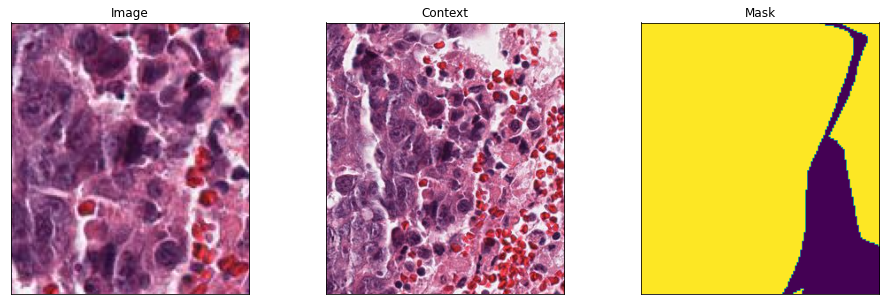

In [12]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir,context_dir, classes=['tumor'])

image, mask, context = dataset[1]
visualize(
      image=image, 
      context=context,
      mask=mask.squeeze(),
  )


In [13]:
smp.encoders.encoders[experiment_name] = {
        "encoder": TigerUnet,
        "params":{}
    }
CLASSES = ['tumor']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

model = smp.Unet(encoder_name=experiment_name,encoder_weights=None,encoder_depth=4, decoder_channels=(256, 128, 64, 32),activation=ACTIVATION,classes=len(CLASSES))

In [14]:
print(
        f"Initialized  model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

Initialized  model with 9977569 total parameters, of which 9977569 are learnable.


In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
# from segmentation_models_pytorch_custom import utils

loss =   smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3,mode='max',verbose=True)

In [17]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = train.TrainSpadeEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = train.ValidSpadeEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [19]:
max_score = 0

train_dice_loss , valid_dice_loss = [], []
train_iou_score, valid_iou_score = [], []

log = {}

for i in range(0, 5):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_dice_loss.append(train_logs['dice_loss'])    
    valid_dice_loss.append(valid_logs['dice_loss'])
    
    train_iou_score.append(train_logs['iou_score'])    
    valid_iou_score.append(valid_logs['iou_score'])
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f"{ROOT_DIR}/Saved_Models/{experiment_name}.pth")
        print('Model saved!')
    scheduler.step(valid_logs['iou_score'])

log['train_dice_loss'] = train_dice_loss
log['valid_dice_loss'] = valid_dice_loss
log['train_iou_score'] = train_iou_score
log['valid_iou_score'] = valid_iou_score

import json
json_file =f"{ROOT_DIR}/Logs/{experiment_name}.json" 
with open(json_file, "w") as file:
	json.dump(log, file)


Epoch: 0
valid: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it, dice_loss - 0.6384, iou_score - 0.2817, fscore - 0.3853]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, dice_loss - 0.6156, iou_score - 0.2817, fscore - 0.3853]

Epoch: 2
valid: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, dice_loss - 0.6149, iou_score - 0.2817, fscore - 0.3853]

Epoch: 3
valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, dice_loss - 0.6148, iou_score - 0.2817, fscore - 0.3853]

Epoch: 4
valid: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it, dice_loss - 0.6147, iou_score - 0.2817, fscore - 0.3853]
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


In [20]:
torch.save(model, f"{ROOT_DIR}/Saved_Models/{experiment_name}.pth")

In [21]:
# load best saved checkpoint
best_model = torch.load(f"{ROOT_DIR}/Saved_Models/{experiment_name}.pth")

In [22]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)

In [23]:
# evaluate model on test set
test_epoch = train.ValidSpadeEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=device,
)

In [24]:
test_dataloader = DataLoader(test_dataset,batch_size=8, shuffle=False, num_workers=0)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it, dice_loss - 0.6973, iou_score - 0.2171, fscore - 0.3027]


In [25]:
# Valid dataset without transformations for image visualization
valid_dataset_vis = Dataset(
    x_valid_dir, y_valid_dir, context_dir,
    classes=CLASSES,
)

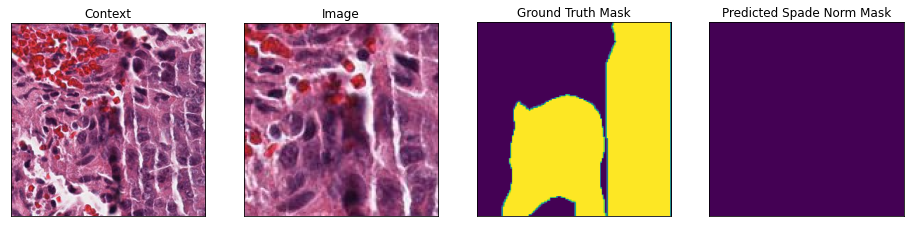

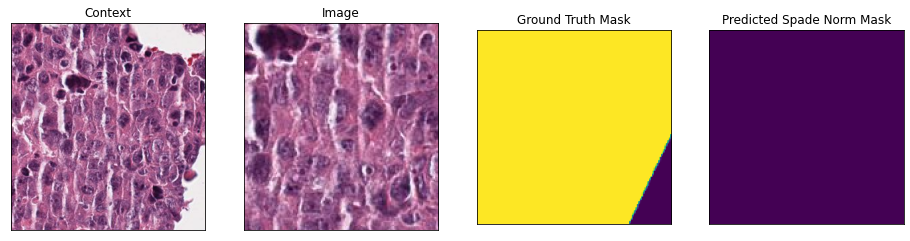

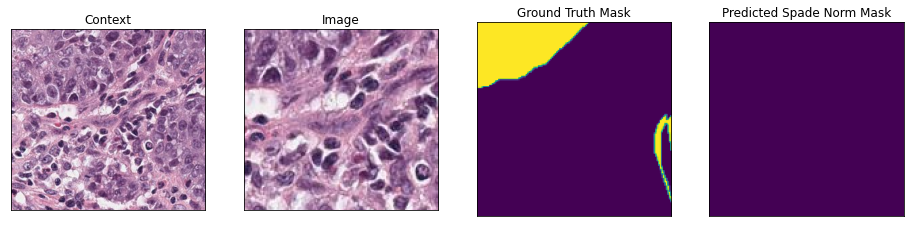

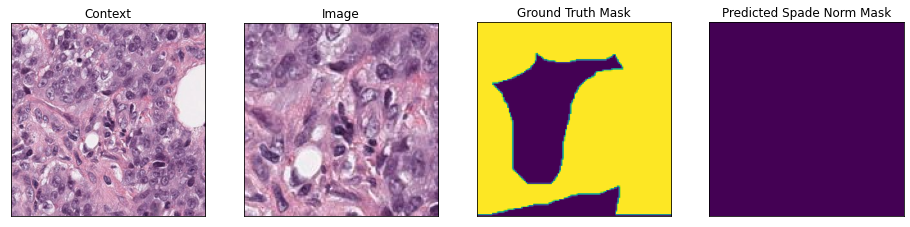

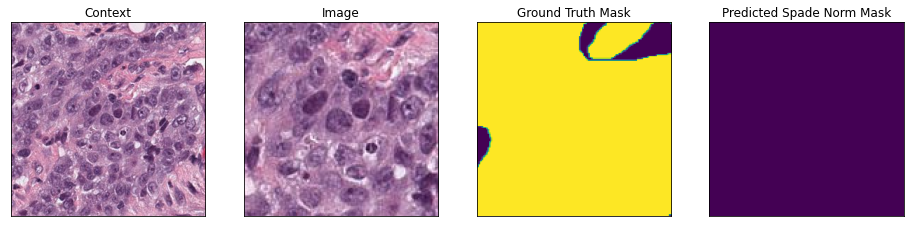

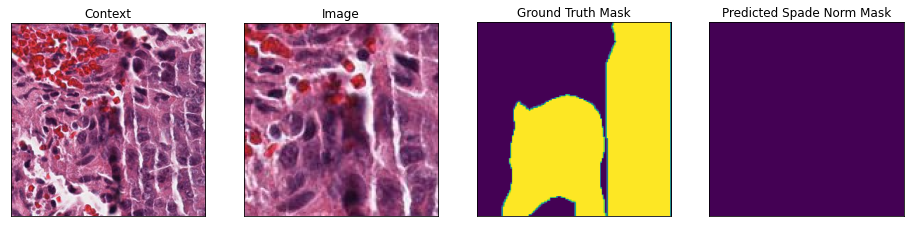

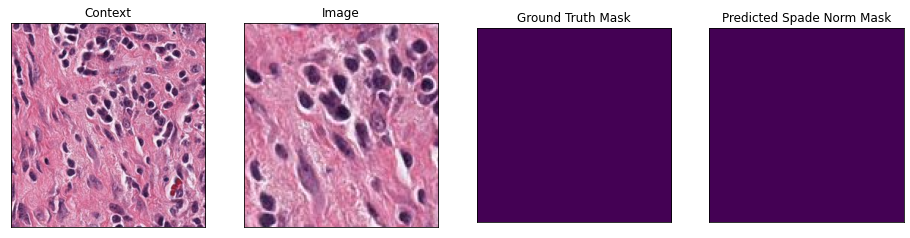

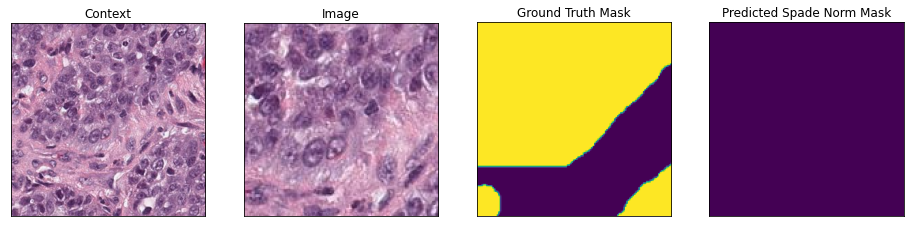

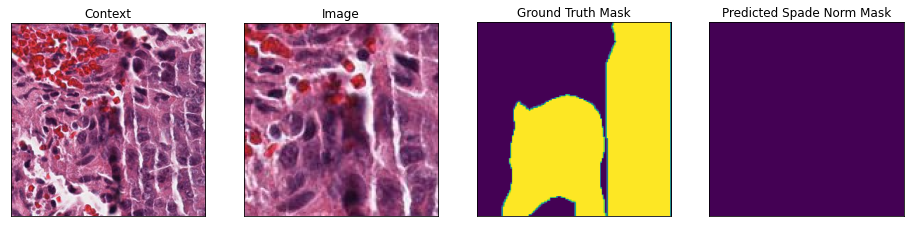

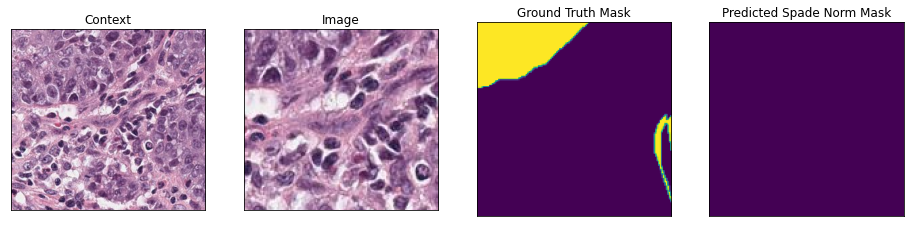

In [26]:
# Note : result is bad because this is a demo notebook and model is trained on only few images.
for i in range(10):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = valid_dataset_vis[n][0].astype('uint8')
    context_vis = valid_dataset_vis[n][2].astype('uint8')
    image, gt_mask, ctx = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
 
    x_tensor = image.to(device).unsqueeze(0)
    ctx_tensor = ctx.to(device).unsqueeze(0)
    pr_mask = best_model.predict((x_tensor,ctx_tensor))
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        context = context_vis,

        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_spade_norm_mask=pr_mask
    )